### Оформление:
1. Оформляйте подробно. Суть проекта и основные шаги должны быть понятны человеку, который эти данные никогда раньше не видел.
2. Структурировать можно, например, так:
    1. Тема проекта, ваши цели
    2. Краткое описание датасета и признаков, которые вы собираетесь использовать в работе
    3. Описание основных шагов:
        * Препроцессинг, работа с данными
        * Математический аппарат, если используете не самые базовые концепции
        
Дедлайн: 1-2 недели после 8 занятия.

## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

# Проверка гипотезы сезонности

## Описание.
https://www.kaggle.com/milanzdravkovic/pharma-sales-data

**Проверка гиротезы**
Есть мнение, что транквилизаторы продаются лучше в декабре.
Проверить, что ЛП из группы `N05B - Psycholeptics drugs, Anxiolytic drugs` имеют повышенные продажи в декабре и это статистически значиымы.

Используется датасет:

Набор данных построен на основе исходного набора данных, состоящего из 600000 транзакционных данных, собранных за 6 лет (период 2014-2019 гг.), С указанием даты и времени продажи, торговой марки фармацевтического препарата и проданного количества, экспортированных из системы точек продаж на индивидуальном уровне. аптека. Выбранная группа препаратов из набора данных (57 препаратов) классифицируется по категориям системы анатомо-терапевтической химической классификации (АТХ).

## Загрузка данных

In [2]:
salesdaily = pd.read_csv('466126_875246_bundle_archive/salesdaily.csv')
salesmonthly = pd.read_csv('466126_875246_bundle_archive/salesmonthly.csv')

In [3]:
salesdaily.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday


## Предобработка

#### Изменим тип колонки "datum"

In [4]:
salesdaily.datum = pd.to_datetime(salesdaily.datum)
salesmonthly.datum = pd.to_datetime(salesmonthly.datum)

In [5]:
print(salesdaily.datum.dt.date.min(),'-',salesdaily.datum.dt.date.max())

2014-01-02 - 2019-10-08


#### Добавим дополнительные колонки

In [6]:
salesdaily['dayofyear'] = salesdaily.datum.dt.dayofyear
salesdaily['month_name'] = salesdaily.datum.dt.month_name()
salesmonthly['month_name'] = salesmonthly.datum.dt.month_name()

#### Выберем только лекарства, относящиеся к классу N05B (Psycholeptics drugs, Anxiolytic drugs)

In [7]:
salesdaily_N05B = salesdaily[['datum', 'N05B', 'Year', 'Month', 'Hour', 'Weekday Name', 'dayofyear', 'month_name']] \
    .rename(columns={'N05B': 'sales'})

In [8]:
salesdaily_N05B.head(3)

,datum,sales,Year,Month,Hour,Weekday Name,dayofyear,month_name
0,2014-01-02,7.0,2014,1,248,Thursday,2,January
1,2014-01-03,16.0,2014,1,276,Friday,3,January
2,2014-01-04,10.0,2014,1,276,Saturday,4,January


## Графический анализ

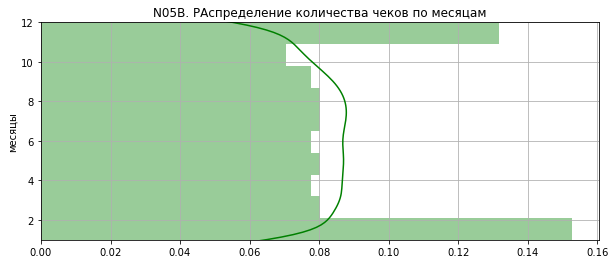

In [9]:
plt.figure(figsize=(10, 4))
sns.distplot(a=salesdaily_N05B.Month, bins=10, axlabel='месяцы', color='green',vertical=1)
plt.title('N05B. РАспределение количества чеков по месяцам')
plt.ylim(1, 12)
plt.grid()

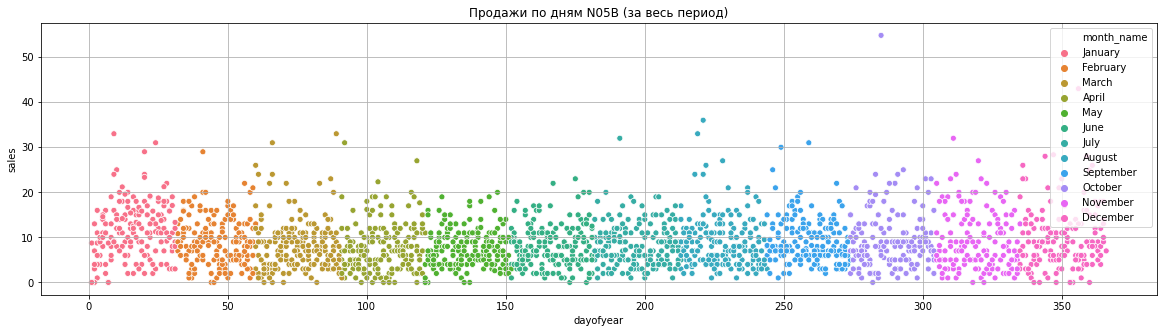

In [10]:
plt.figure(figsize=(20, 5))
sns.scatterplot(
    x='dayofyear',
    y='sales',
    hue='month_name',
    data=salesdaily_N05B,
)
plt.title('Продажи по дням N05B (за весь период)')
plt.grid()

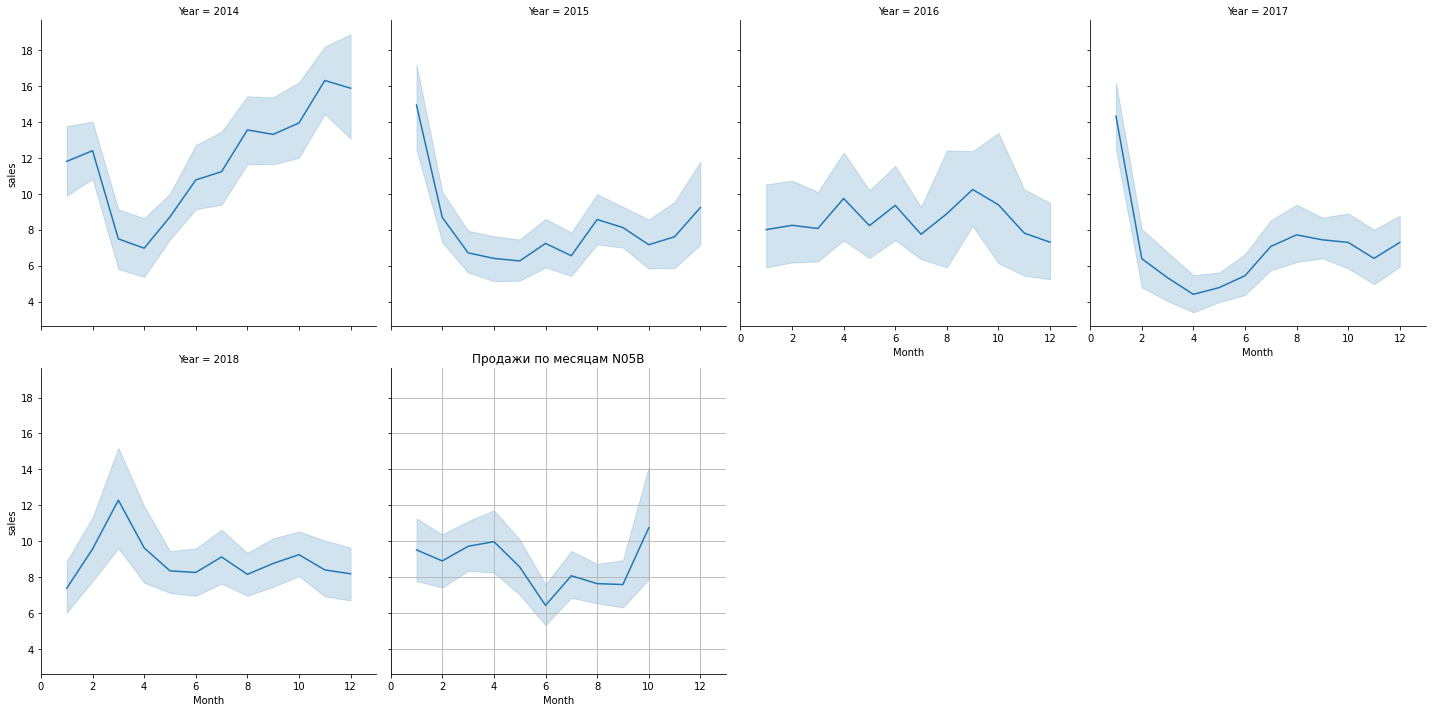

In [11]:
sns.relplot(x="Month", y="sales", data=salesdaily_N05B,
            kind="line",
            col='Year', col_wrap=4,
)
plt.title('Продажи по месяцам N05B')
plt.xlim(0,13)
plt.grid();

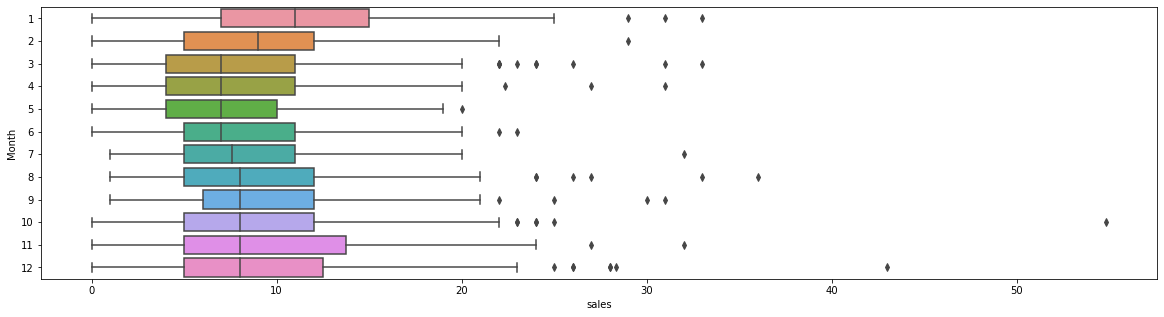

In [12]:
plt.figure(figsize=(20,5))
sns.boxplot(x="sales", y="Month",  orient='h', data=salesdaily_N05B);

---

## Проверка гипотезы

[Wikipedia/Двухвыборочный t-критерий для независимых выборок](https://ru.wikipedia.org/wiki/T-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0#%D0%94%D0%B2%D1%83%D1%85%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_t-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%B4%D0%BB%D1%8F_%D0%BD%D0%B5%D0%B7%D0%B0%D0%B2%D0%B8%D1%81%D0%B8%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BE%D0%BA)

Пусть имеются две независимые выборки объёмами n<sub>1</sub> и n<sub>2</sub> нормально распределённых случайных величин X<sub>1</sub>, X<sub>2</sub>. Необходимо проверить по выборочным данным нулевую гипотезу равенства математических ожиданий этих случайных величин H<sub>0</sub>: M<sub>1</sub> = M<sub>2</sub>.

- Нулевая гипотеза: Продажи в декабре не выше, чем среднеготовые
- Альтернативная гипотеза: Продажи в декабре значимо выше, чем среднеготовые

In [20]:
X_1 = salesdaily_N05B[salesdaily_N05B['month_name'] != 'December'].sales
X_2 = salesdaily_N05B[salesdaily_N05B['month_name'] == 'December'].sales

In [21]:
def ss(X):
    return np.sum((X - X.mean())**2)

t_statistic = (X_2.mean() - X_1.mean()) / np.sqrt(ss(X_1) / X_1.shape[0] + ss(X_2) / X_2.shape[0])
t_statistic

0.08889012363139215

In [22]:
alpha = 0.05
n = X_1.shape[0]

t1 = stats.t.ppf(alpha / 2, df=n - 1)
t2 = stats.t.ppf(1 - alpha / 2, df=n - 1)
t1, t2

(-1.9611812765081829, 1.9611812765081824)

In [23]:
if t1 <= t_statistic <= t2:
    print('Значение попало в критическую область.\nНулевая гипотеза отвергается.\nСезонность значима!')
else:
    print('Значение НЕ попало в критическую область.\nНулевая гипотеза принимается.\nСезонность незначительна')

Значение попало в критическую область.
Нулевая гипотеза отвергается.
Сезонность значима!
